In [1]:
import cv2
import numpy
import glob
from matplotlib import pyplot as plt 
from scipy import io
import numpy as np
import time

In [2]:
focus = io.loadmat('Image/logitech/logi03/focus.mat')
lens_position= focus['u'][0]
img_list = sorted(glob.glob('Image/logitech/logi03/*.bmp'))
imgs = []
dsts = []

In [3]:
for img_path in img_list:
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#     imgs.append(img.astype('int16')) # RGB datatype is unit8
    imgs.append(img)

In [4]:
np.size(imgs[0])

921600

In [5]:
def cal_contrast(img, ROI=None):
    contrast = 0
    dst = img.astype('int16')
    if ROI==None:
        ROI=[0, 0, img.shape[1], img.shape[0]]
    xs, ys = ROI[0], ROI[1]
    width, height = ROI[2], ROI[3]
    dstROI = dst[ys:ys+height, xs:xs+width]
    dstRoll = np.roll(dstROI, 1, axis=0)
    contrast_arr = np.square((dstROI - dstRoll)[1:])
    contrast = np.sum(contrast_arr)
    contrast_per_pixel = float(contrast) / float(np.size(dst))
    return contrast_per_pixel

In [6]:
# ROI = [300, 600, 180, 168]
contrast_list = [cal_contrast(img) for img in imgs]

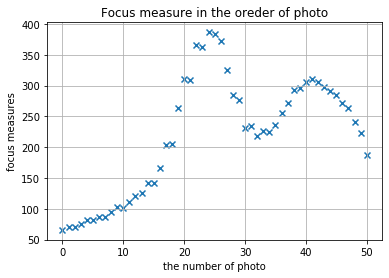

In [7]:
plt.scatter(range(len(contrast_list)), contrast_list, marker='x', label='contrast')
plt.title('Focus measure in the oreder of photo')
plt.xlabel('the number of photo')
plt.ylabel('focus measures')
plt.grid()
plt.show()

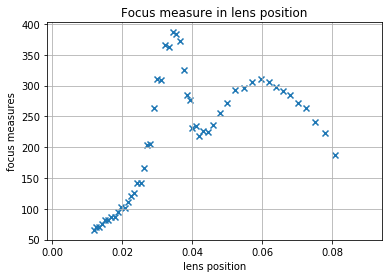

In [8]:
plt.scatter(lens_position, contrast_list,marker='x', label='contrast')
plt.title('Focus measure in lens position')
plt.xlabel('lens position')
plt.ylabel('focus measures')
plt.grid()
plt.show()

In [9]:
def make_fibonacci(N):
    if N is 1:
        return [0]
    elif N is 2:
        return [0, 1]
    
    fibonacci_list = [0, 1]
    for i in range(2, N):
        fib = fibonacci_list[i-1] + fibonacci_list[i-2]
        fibonacci_list.append(fib)
    return fibonacci_list


In [10]:
def fibonacci_search(imgs, N, a, b, tolerance):
    contrast_list = []
    fibonacci_list = make_fibonacci(N)
    
    x, y = a, b
    dst_x = cv2.cvtColor(imgs[x], cv2.COLOR_BGR2GRAY)
    dst_y = cv2.cvtColor(imgs[y], cv2.COLOR_BGR2GRAY)
    fx = cal_contrast(dst_x)
    fy = cal_contrast(dst_y)
    error = abs(fx - fy)
    
    for i in range(N-2):
        L = y - x
        if error < tolerance:
            i = i - 1
            break
            
        print('-'*50)
        print(f'\niteration: {i} ')
        print(f'[x, y]: [{x}, {y}]')
        print(f'error: {error}')
        
        x1 = int(x + (fibonacci_list[N-i-3] / fibonacci_list[N-i-1] ) * L)
        y1 = int(y - (fibonacci_list[N-i-3] / fibonacci_list[N-i-1] ) * L)
        dst_x1 = cv2.cvtColor(imgs[x1], cv2.COLOR_BGR2GRAY)
        dst_y1 = cv2.cvtColor(imgs[y1], cv2.COLOR_BGR2GRAY)
        fx1 = cal_contrast(dst_x1)
        fy1 = cal_contrast(dst_y1)

        if fx1 < fy1:
            print(f'x is changed {x} -> {x1}\n')  
            x = x1
            fx = fx1
            
        else:
            print(f'y is changed {y} -> {y1}\n')
            y = y1
            fy = fy1
        error = abs(fx - fy)
        
    print('Search is finished!')
    print('-'*10)
    print(f'total iteration: {i+1} ')
    print(f'[x, y]: [{x}, {y}]')
    print(f'final error: {error}\n\n')
    if fx > fy:
        print(f'maximum value: {fx} ,index: {x}')
        return x, fx
    else:
        print(f'maximum value: {fy} ,index: {y}')
        return y, fy

In [11]:
N = 20
tolerance = 2e+6 / np.size(imgs[0])

start = time.time()
max_index, max_fm = fibonacci_search(imgs, 20, 0, len(imgs)-1, tolerance)
print(f'excution time: {(time.time() - start):.3f}s')



--------------------------------------------------

iteration: 0 
[x, y]: [0, 50]
error: 118.906806640625
y is changed 50 -> 30

--------------------------------------------------

iteration: 1 
[x, y]: [0, 30]
error: 165.69759114583334
x is changed 0 -> 11

--------------------------------------------------

iteration: 2 
[x, y]: [11, 30]
error: 119.18350911458334
x is changed 11 -> 18

--------------------------------------------------

iteration: 3 
[x, y]: [18, 30]
error: 24.159654947916692
x is changed 18 -> 22

--------------------------------------------------

iteration: 4 
[x, y]: [22, 30]
error: 137.24488932291666
y is changed 30 -> 26

--------------------------------------------------

iteration: 5 
[x, y]: [22, 26]
error: 4.526705729166679
x is changed 22 -> 23

--------------------------------------------------

iteration: 6 
[x, y]: [23, 26]
error: 8.569941406249995
y is changed 26 -> 24

--------------------------------------------------

iteration: 7 
[x, y]: [23, 24]


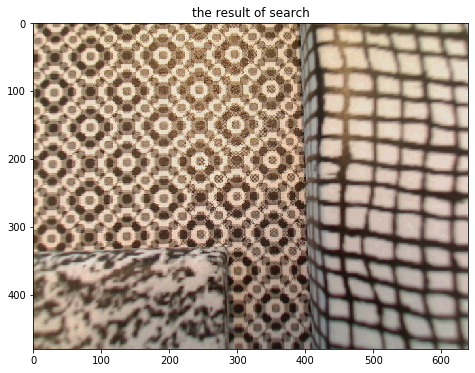

In [17]:
plt.figure(figsize=(10,6))
# plt.axis('off')
plt.title('The result of search')
plt.imshow(imgs[max_index])